In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import datetime
import glob
import pickle
from datetime import datetime, timedelta
import sys
from scipy.optimize import curve_fit
from matplotlib.lines import Line2D

#import the folder that has the analysis level class
sys.path.append("../CombinedData/")
sys.path.append("../AnalysisTools/")
import Dataset
import AnalysisTools

In [6]:
topdirs = {7:"../../data/Run7/", 8:"../../data/Run8/", 9:"../../data/Run9/", 10:"../../data/Run10/"}
configs = {5:"../configs/run5_config.yaml", 6:"../configs/run6_config.yaml", 7:"../configs/run7_config.yaml", 8:"../configs/run8_config.yaml", 9:"../configs/run9_config.yaml", 10:"../configs/run10_config.yaml"}
titles = {5:"SS304 uncoated", 6:"Refill of SS304 uncoated", 7:"MgF2 (50nm)", 8:"Pt (50nm)", 9:"MgF2 (20nm)", 10:"SS304 - w/ bkgnd"}
red_file_name = "combined_reduced.p"
#analysis tools objects, unloaded data
anas = {}
for n in topdirs:
    anas[n] = AnalysisTools.AnalysisTools(topdirs[n]+red_file_name, configs[n], title=titles[n], ramp_topdir=topdirs[n])



/Users/ejangelico/Documents/Stanford/GasBreakdownChamber/code/ad2-data-processing/notebooks/../AnalysisTools/AnalysisTools.py:137: UserWarning: genfromtxt: Empty input file: "../../data/Run8/ds03/g_events.txt"
  d = np.genfromtxt(os.path.join(root, self.config["g_events_name"]), delimiter=',', dtype=float)


In [7]:
#load data into mem if you want
for n, ana in anas.items():
    if(n==5 or n == 6): continue
    ana.load_dataframe()

## PMT Amplitudes

In [ ]:
#reproduce some of the plots above
for run, ana in anas.items():
    d = ana.df
    fig, ax = plt.subplots()
    h = np.array(d["ch0 amp"])
    h = h[~np.equal(h, None)]
    binwidth = 10 #mV
    bins = np.arange(min(h), max(h), binwidth)
    ax.hist(h, bins=bins, label="ch 0", alpha=0.6)

    h = np.array(d["ch1 amp"])
    h = h[~np.equal(h, None)]
    binwidth = 10 #mV
    bins = np.arange(min(h), max(h), binwidth)
    ax.hist(h, bins=bins, label="ch 1", alpha=0.6)

    ax.legend()
    ax.set_xlabel("primary pulse amplitude [mV]")
    ax.set_ylabel("events per {:.1f} mV binwidth".format(binwidth))
    ax.set_title("All PMT primary amplitudes in run {:d} ({:d} events)".format(run, len(h)))
    ax.set_yscale('log')
    plt.show()

In [ ]:
d = anas[7].df

fig, ax = plt.subplots()
h1 = np.array(d["ch0 trigger integral"])
#h1 = h1[~np.equal(h, None)]
h2 = np.array(d["ch0 amp"])
#h2 = h2[~np.equal(h, None)]
ax.scatter(h2, h1, alpha=0.2, s=5, label="All PMT events during HV ramping")

d = ds.reduced_df
h1 = np.array(d["ch0 trigger integral"])
#h1 = h1[~np.equal(h, None)]
h2 = np.array(d["ch0 amp"])
#h2 = h2[~np.equal(h, None)]
ax.scatter(h2, h1, alpha=0.2, s=5, label="Cosmics no HV")


ax.legend(markerscale=8)
ax.set_ylim([-1, 6])
ax.set_xlim([0, 200])
ax.set_xlabel("primary pulse amplitude [mV]")
ax.set_ylabel("primary pulse integral [mV*us]")
ax.set_title("All of Run 7 PMT events, at 0V and HV ramping separated")
#ax.set_yscale('log')
plt.show()

In [ ]:
for run, ana in anas.items():
    d = ana.df
    ch0_int = np.array(d["ch0 afterpulse integral"])
    ch0_int = ch0_int[~np.equal(ch0_int, None)]
    ch0_base = np.array(d["ch0 postbaseline"])
    ch0_base = 7.5*ch0_base[~np.equal(ch0_base, None)]
    ch0_int = ch0_int - ch0_base

    ch1_int = np.array(d["ch1 afterpulse integral"])
    ch1_int = ch1_int[~np.equal(ch1_int, None)]
    ch1_base = np.array(d["ch1 postbaseline"])
    ch1_base = 7.5*ch1_base[~np.equal(ch1_base, None)]
    ch1_int = ch1_int - ch1_base

    total_int = ch1_int + ch0_int

    fig, ax = plt.subplots()
    ax.hist(total_int, 100)
    ax.set_yscale('log')
    plt.show()


## Anode charge

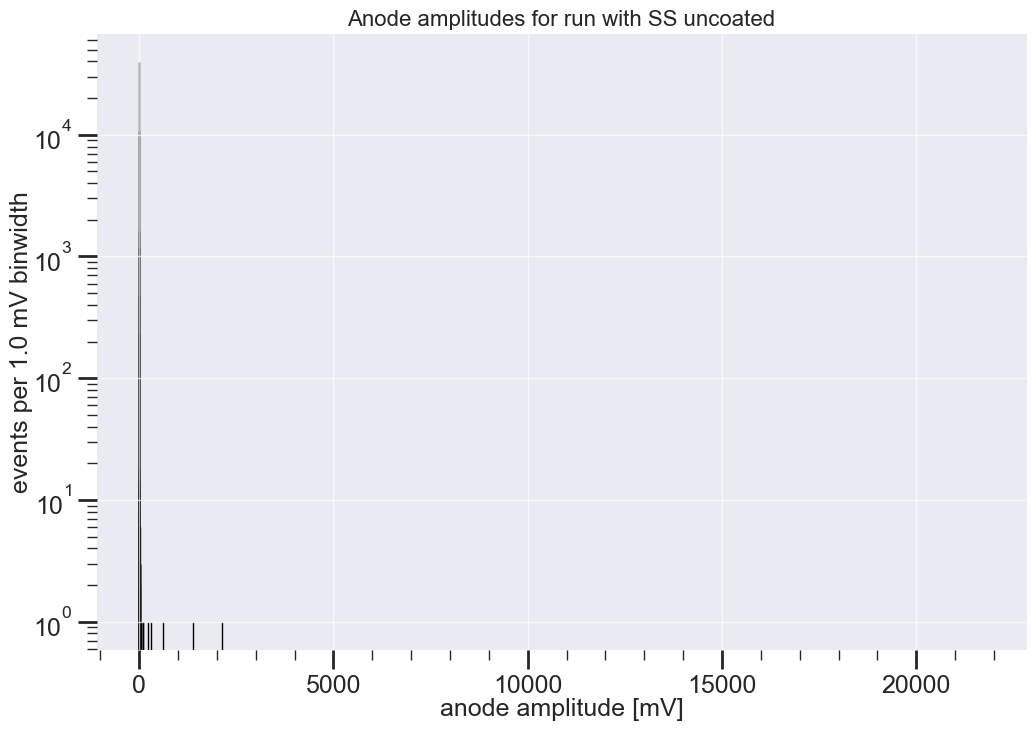

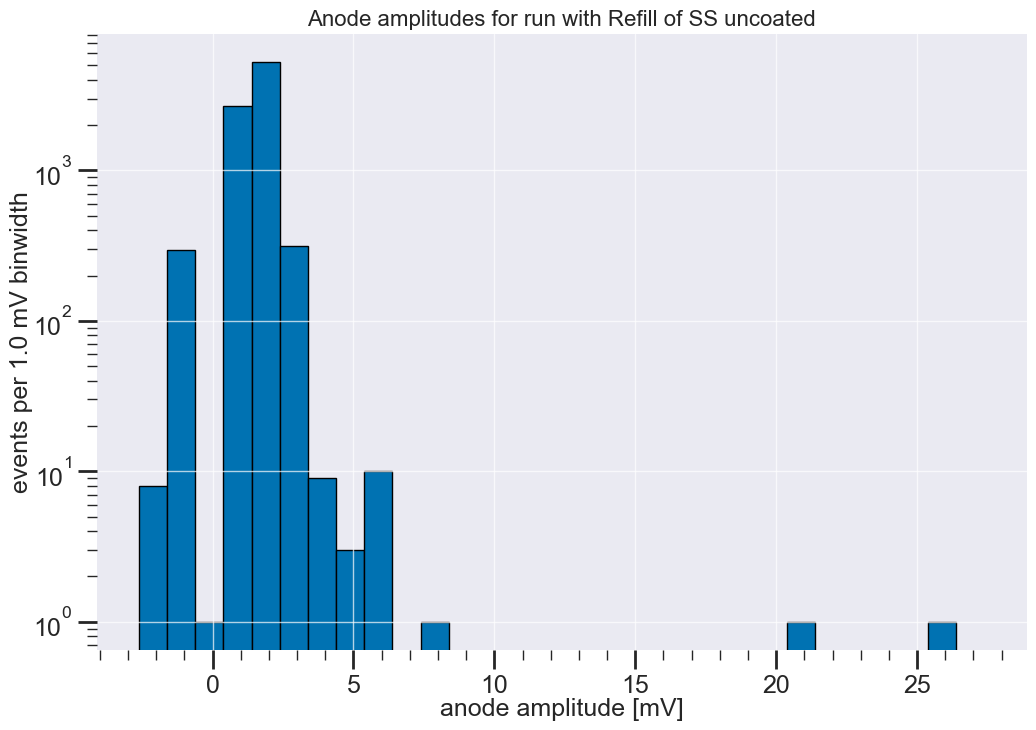

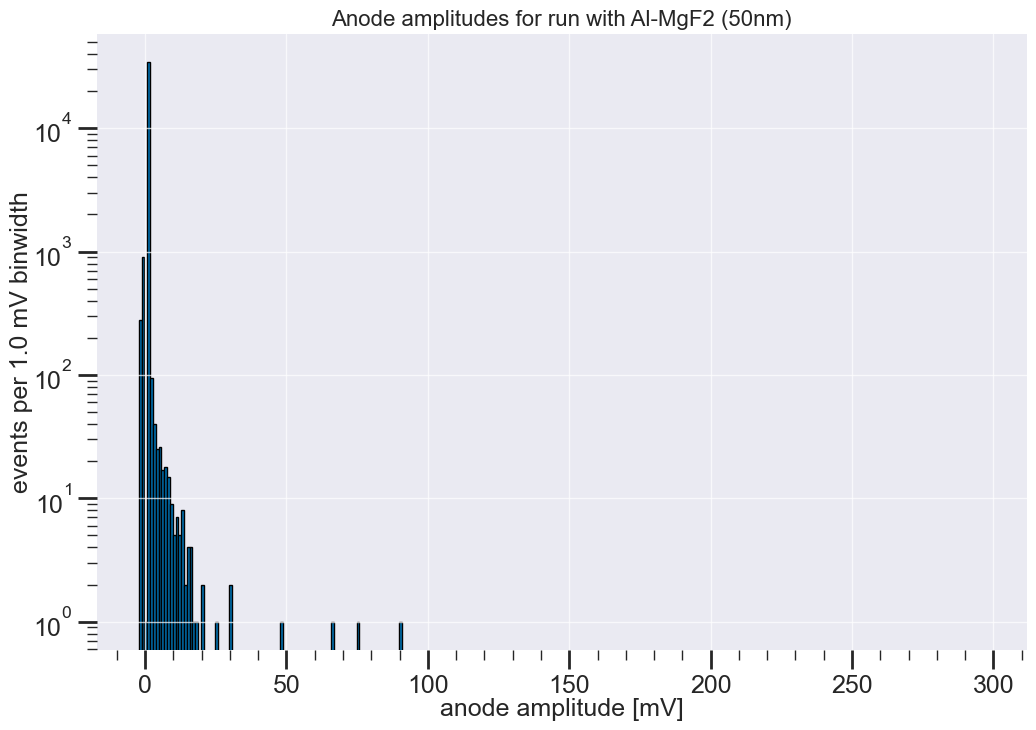

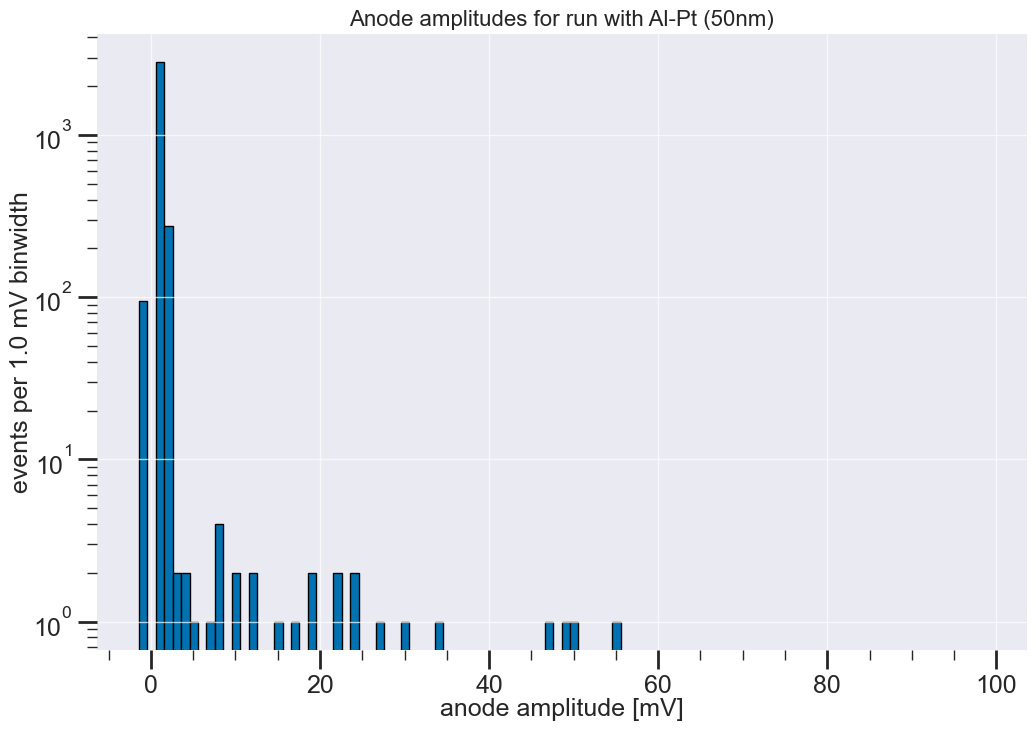

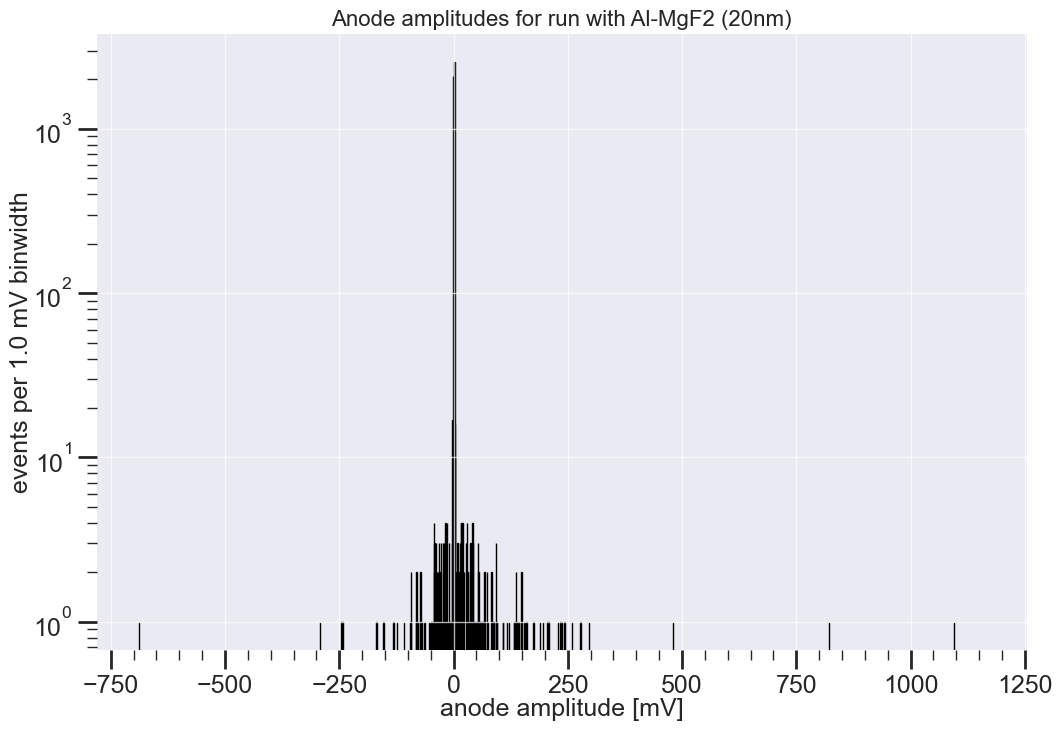

In [7]:
for run, ana in anas.items():
    fig, ax = plt.subplots()
    d = ana.df
    ampdf = d[~d["ch3 amp"].isna()]
    h = np.array(ampdf["ch3 amp"])
    binwidth = 1 #mV
    #protect against huge bounds and misreconstructed amplitudes
    bins = np.arange(np.min(h), np.max(h), binwidth)
    ax.hist(h, bins=bins)

    ax.set_xlabel("anode amplitude [mV]")
    ax.set_ylabel("events per {:.1f} mV binwidth".format(binwidth))
    ax.set_title("Anode amplitudes for run with " + ana.title)
    ax.set_yscale('log')
    plt.show()

## Peak multiplicities

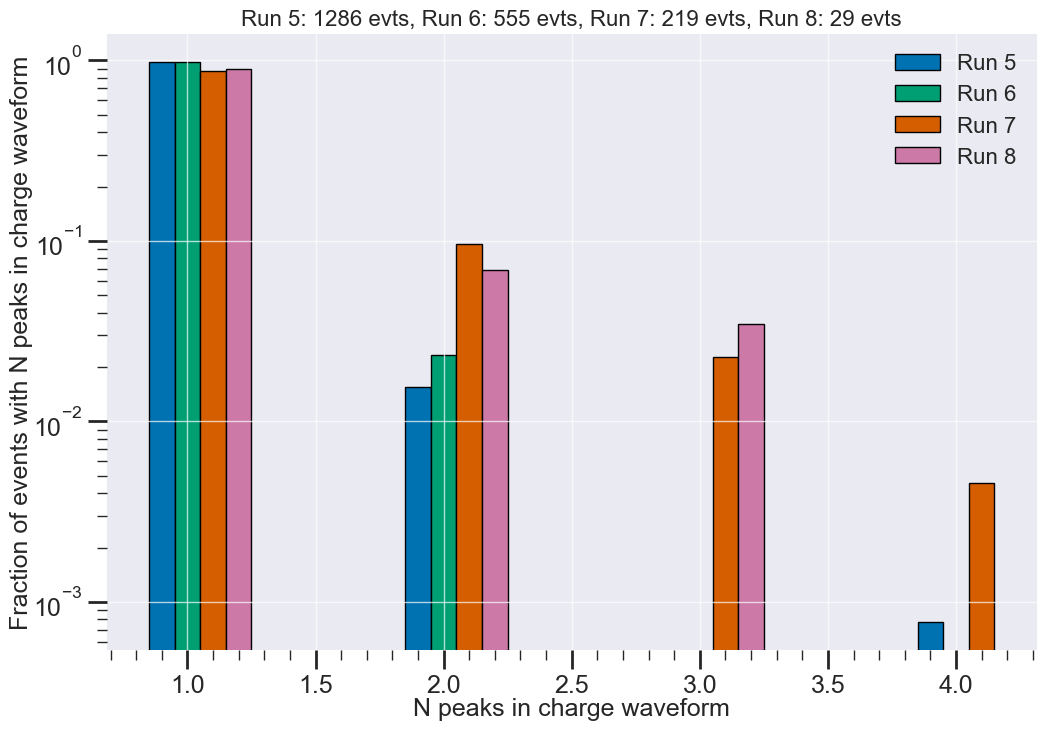

In [16]:
#Multiplicities
fig, ax = plt.subplots()
barwidth = 0.1
total_events_run = {}
for i, (run, ana) in enumerate(anas.items()):
    d = ana.df
    npeaks = np.array(d["ch3 n peaks"])
    npeaks = npeaks[~np.equal(npeaks, None)]
    npeaks_set = list(set(npeaks))
    npeaks_count = {}
    total_nonzero = 0
    for n in npeaks_set:
        npeaks_count[n] = len(np.where(npeaks == n)[0])
        if(n != 0):
            total_nonzero += npeaks_count[n]
    plotlist = []
    for n in npeaks_count:
        if(n == 0): continue
        plotlist.append(npeaks_count[n]/total_nonzero)
    
    total_events_run[run] = total_nonzero


    pos = np.array([_ for _ in npeaks_count if _ != 0])
    ax.bar(pos + (i - 1)*barwidth, plotlist, barwidth, label="Run {:d}".format(run))

ax.legend()
ax.set_yscale('log')
ax.set_ylabel("Fraction of events with N peaks in charge waveform")
ax.set_xlabel("N peaks in charge waveform")
ax.set_title("Run 5: {:d} evts, Run 6: {:d} evts, Run 7: {:d} evts, Run 8: {:d} evts".format(total_events_run[5],total_events_run[6],total_events_run[7], total_events_run[8]))
plt.show()


In [ ]:
#Multiplicities

for i, (run, ana) in enumerate(anas.items()):
    fig, ax = plt.subplots()
    d = ana.df
    npeaks = np.array(d["ch3 n peaks"])
    npeaks = npeaks[~np.equal(npeaks, None)]
    kv = np.array(d["ch3 hv"])
    kv = kv[~np.equal(kv, None)]
    ax.scatter(kv, npeaks, alpha=0.5, s=30)
    

    #ax.legend()
    ax.set_ylabel("N peaks in charge waveform")
    ax.set_xlabel("HV applied [kV]")
    ax.set_title("Run {:d}".format(run))
    #ax.set_xlim([5, 15])
    plt.show()


# Waveform plotting tools, which require cluster operation for access to prereduced

In [ ]:
#waveform plotting tool (not tested, need cluster where all prereduced data sits. )
for run, ana in anas.items():
    d = ana.df
    mask = (d["ch3 amp"] > 20)
    sw_chs = [3]
    events = ana.get_waveforms_from_cuts(mask, sw_chs)[3]
    fig, ax = plt.subplots()
    for ev in events:
        times = np.arange(0, ev["dT"]*1e6*len(ev["Data"][0]), ev["dT"]*1e6)
        ax.plot(times, ev["Data"][0])

    ax.legend()
    ax.set_xlabel("time [us]")
    ax.set_ylabel('[mV]')
    ax.set_title("run {:d} ({:d} events)".format(run, len(events)))
    plt.show()

## History plots

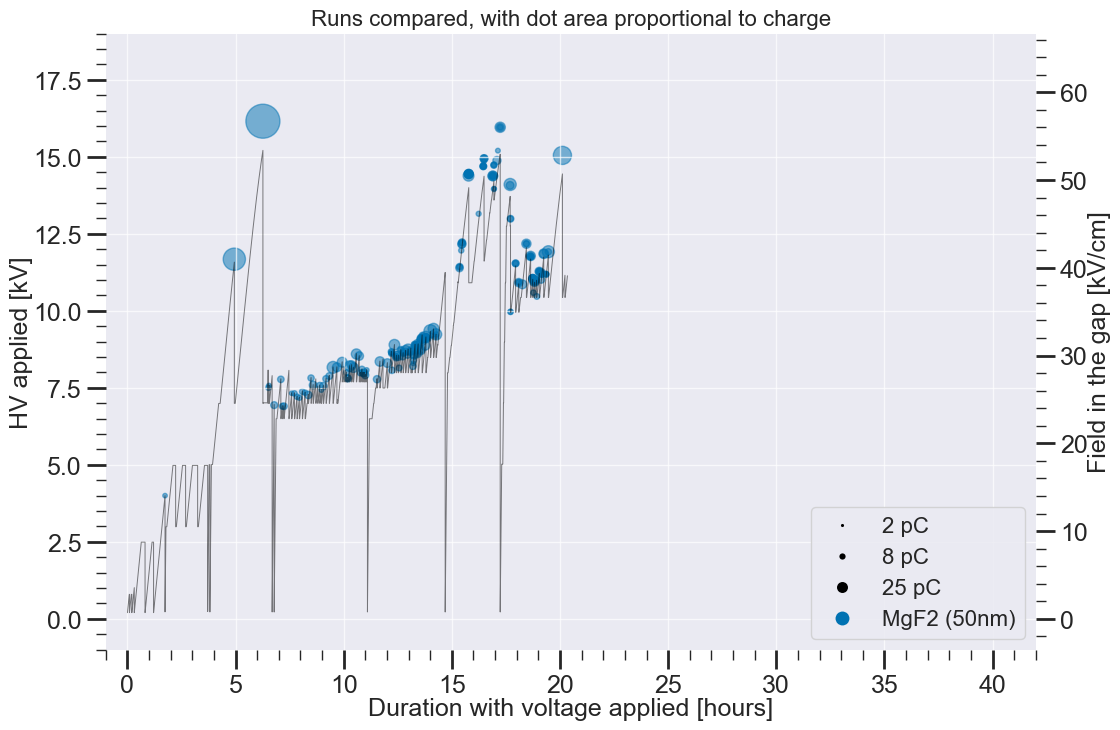

In [11]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors[1] = 'darkgreen'
charge_dot_scale = 10

fig, ax = plt.subplots()
ax.set_ylim([-1, 19]) #fixed axis for all
ax.set_xlim([-1, 42])
ax2 = ax.twinx()
E_f = lambda V:V/0.285
ymin, ymax = ax.get_ylim()
ax2.set_ylim(E_f(ymin), E_f(ymax))
ax2.plot([], [])

# Define custom legend entries with markers
legend_elements = [\
    Line2D([0], [0], marker='o', linewidth=0, color='k', markersize=np.sqrt(2*charge_dot_scale)/2, label='2 pC'),
    Line2D([0], [0], marker='o', linewidth=0, color='k', markersize=np.sqrt(8*charge_dot_scale)/2, label='8 pC'),
    Line2D([0], [0], marker='o', linewidth=0, color='k', markersize=np.sqrt(25*charge_dot_scale)/2, label='25 pC')]

for i, run in enumerate([7]):
    ana = anas[run]
    d = ana.df
    d = d[~d["ch3 charge"].isna()]
    

    #negative polar events
    mask = (d["ch3 n negpeaks"] > 0) & (d["ch3 n pospeaks"] == 0) & (np.abs(d["ch3 charge"]) > 1)
    #if(run == 10):
        #mask = (np.abs(d["ch3 charge"]) > 2) #positive peaks allowed, because it was the only thing observed. 
    d_ch = np.abs(np.array(d[mask]["ch3 charge"]))
    d_sec = np.array(d[mask]["ch3 seconds"])
    d_nsec = np.array(d[mask]["ch3 nanoseconds"])
    d_hv = np.array(d[mask]["ch3 hv"])
    d_E = np.array(d[mask]["ch3 field"])

    #recast time
    hv_event_durs = [ana.get_duration_from_timestamp(_)/3600 for _ in d_sec]
    ax.scatter(hv_event_durs, d_hv, s=list(np.array(d_ch)*charge_dot_scale), marker='o', alpha=0.5, facecolor=colors[i], edgecolor=colors[i])
    #ax.scatter(hv_event_durs, [ana.get_hv_at_time(d_sec[_] + d_nsec[_]/1e9) for _ in range(len(d_sec))], s=list(np.array(d_ch)*charge_dot_scale), marker='x', alpha=1, facecolor=colors[i], edgecolor=colors[i])
    #ax.plot(hv_event_durs, d_hv, 'k-', alpha=0.3)
    #negative polar events
    mask = (d["ch3 n negpeaks"] == 0) & (d["ch3 n pospeaks"] > 0) 
    d_ch = np.abs(np.array(d[mask]["ch3 charge"]))
    d_sec = np.array(d[mask]["ch3 seconds"])
    d_hv = np.array(d[mask]["ch3 hv"])
    d_E = np.array(d[mask]["ch3 field"])

    #duration curve
    ax.plot(np.array(ana.time_duration_map["dur"])/3600, ana.time_duration_map["v"], 'k-', linewidth=0.7, alpha=0.5)
    
    legend_elements.append(Line2D([0], [0], marker='o', linewidth=0, color=colors[i], markersize=10, label=ana.title))


# Add legend with custom legend entries and solid color bounding background box
ax.legend(handles=legend_elements, loc='lower right', frameon=True)

ax.set_ylabel("HV applied [kV]")
ax2.set_ylabel("Field in the gap [kV/cm]")
#ax.set_xlim([0, 2])
ax2.grid(False)
ax.set_xlabel("Duration with voltage applied [hours]")
ax.set_title("Runs compared, with dot area proportional to charge")
plt.show()


Time duration map is not constructed. Please load hv textfiles and identify ramps.


TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

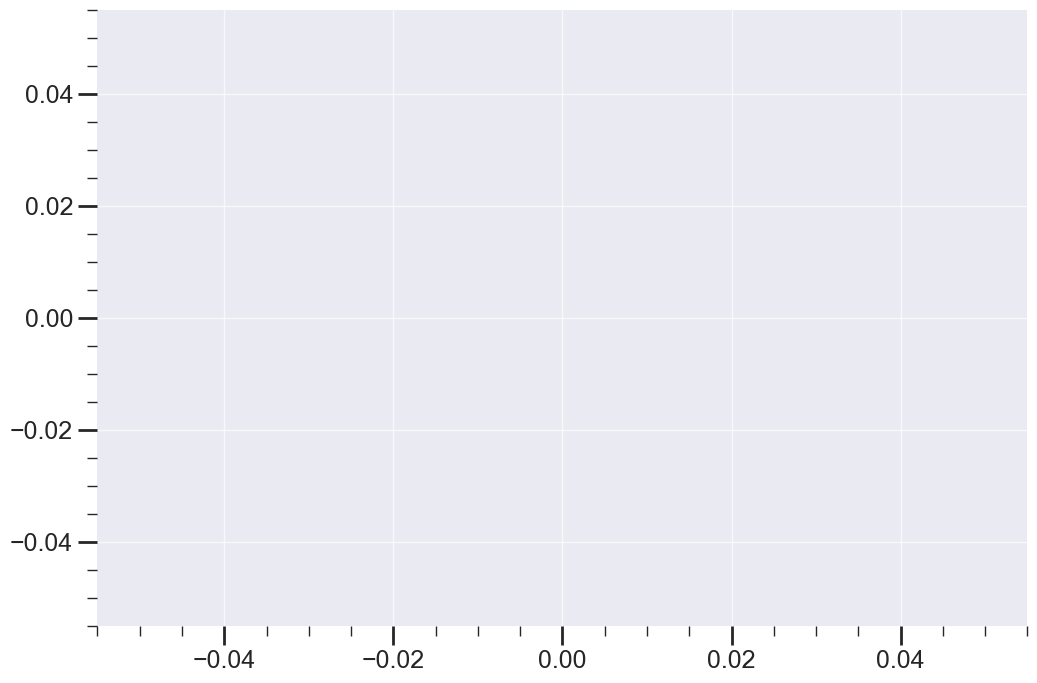

In [8]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors[1] = 'darkgreen'
charge_dot_scale = 10



# Define custom legend entries with markers
legend_elements = [\
    Line2D([0], [0], marker='o', linewidth=0, color='k', markersize=np.sqrt(2*charge_dot_scale)/2, label='2 pC'),
    Line2D([0], [0], marker='o', linewidth=0, color='k', markersize=np.sqrt(8*charge_dot_scale)/2, label='8 pC'),
    Line2D([0], [0], marker='o', linewidth=0, color='k', markersize=np.sqrt(25*charge_dot_scale)/2, label='25 pC')]

for i, run in enumerate([7,8,9, 10]):
    fig, ax = plt.subplots()
    #ax.set_ylim([-1, 19]) #fixed axis for all
    #ax.set_xlim([-1, 42])
    
    ana = anas[run]
    d = ana.df
    d = d[~d["ch3 charge"].isna()]
    tdmap = ana.time_duration_map
    ax.plot(np.array(tdmap["dur"])/3600, tdmap["v"], color='k', linewidth=0.7, alpha=0.5)

    #negative polar events
    mask = (d["ch3 n negpeaks"] > 0) & (d["ch3 n pospeaks"] == 0)# & (np.abs(d["ch3 charge"]) > 1)
    d_ch = np.abs(np.array(d[mask]["ch3 charge"]))
    d_sec = np.array(d[mask]["ch3 seconds"])
    d_hv = np.array(d[mask]["ch3 hv"])
    d_E = np.array(d[mask]["ch3 field"])

    #recast time
    hv_event_durs = [ana.get_duration_from_timestamp(_)/3600 for _ in d_sec]
    ax.scatter(hv_event_durs, d_hv, s=list(np.array(d_ch)*charge_dot_scale), marker='o', alpha=0.5, facecolor=colors[i], edgecolor=colors[i])

    #positive polar
    mask = (d["ch3 n pospeaks"] > 1)# & (np.abs(d["ch3 charge"]) > 1)
    d_ch = np.abs(np.array(d[mask]["ch3 charge"]))
    d_sec = np.array(d[mask]["ch3 seconds"])
    d_hv = np.array(d[mask]["ch3 hv"])
    d_E = np.array(d[mask]["ch3 field"])

    #recast time
    hv_event_durs = [ana.get_duration_from_timestamp(_)/3600 for _ in d_sec]
    ax.scatter(hv_event_durs, d_hv, s=list(np.array(d_ch)*charge_dot_scale), marker='v', alpha=0.5, facecolor=colors[i], edgecolor=colors[i])

    ax2 = ax.twinx()
    E_f = lambda V:V/0.285
    ymin, ymax = ax.get_ylim()
    ax2.set_ylim(E_f(ymin), E_f(ymax))
    ax2.plot([], [])
        
    # Add legend with custom legend entries
    ax.legend(handles=legend_elements, loc='lower right')
    ax.set_ylabel("HV applied [kV]")
    ax2.set_ylabel("Field in the gap [kV/cm]")
    ax2.grid(False)
    ax.set_xlabel("Duration with voltage applied [hours]")
    ax.set_title("Run with {} cathode, dot area proportional to charge deposited, time between ramps is collapsed".format(ana.title))
    plt.show()




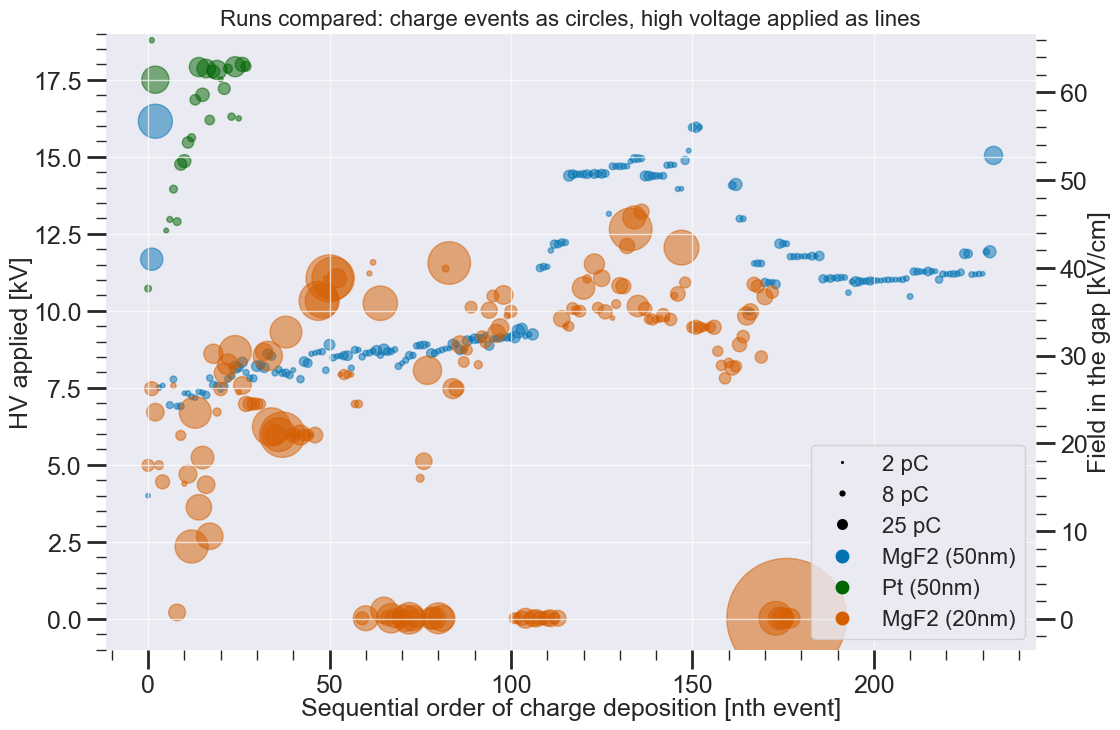

In [9]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors[1] = 'darkgreen'
charge_dot_scale = 10

fig, ax = plt.subplots()
ax.set_ylim([-1, 19]) #fixed axis for all
#ax.set_xlim([-1, 42])
ax2 = ax.twinx()
E_f = lambda V:V/0.285
ymin, ymax = ax.get_ylim()
ax2.set_ylim(E_f(ymin), E_f(ymax))
ax2.plot([], [])

# Define custom legend entries with markers
legend_elements = [\
    Line2D([0], [0], marker='o', linewidth=0, color='k', markersize=np.sqrt(2*charge_dot_scale)/2, label='2 pC'),
    Line2D([0], [0], marker='o', linewidth=0, color='k', markersize=np.sqrt(8*charge_dot_scale)/2, label='8 pC'),
    Line2D([0], [0], marker='o', linewidth=0, color='k', markersize=np.sqrt(25*charge_dot_scale)/2, label='25 pC')]

for i, run in enumerate([7,8,9]):
    ana = anas[run]
    d = ana.df
    d = d[~d["ch3 charge"].isna()]

    #get all events with any amount of charge
    mask = ((d["ch3 n negpeaks"] > 0) | (d["ch3 n pospeaks"] == 0)) & (np.abs(d["ch3 charge"]) > 1)
    d_ch = np.array(d[mask]["ch3 charge"])
    d_sec = np.array(d[mask]["ch3 seconds"])
    d_hv = np.array(d[mask]["ch3 hv"])

    #sort all three lists by the order of d_sec
    d_sec, d_ch, d_hv = zip(*sorted(zip(d_sec, d_ch, d_hv)))

    ax.scatter(range(len(d_hv)), d_hv, s=list(np.abs(np.array(d_ch))*charge_dot_scale), marker='o', alpha=0.5, facecolor=colors[i], edgecolor=colors[i])
    legend_elements.append(Line2D([0], [0], marker='o', linewidth=0, color=colors[i], markersize=10, label=ana.title))


# Add legend with custom legend entries and solid color bounding background box
ax.legend(handles=legend_elements, loc='lower right', frameon=True)
    
ax.set_ylabel("HV applied [kV]")
ax2.set_ylabel("Field in the gap [kV/cm]")
ax2.grid(False)
ax.set_xlabel("Sequential order of charge deposition [nth event]")
ax.set_title("Runs compared: charge events as circles, high voltage applied as lines")
plt.show()

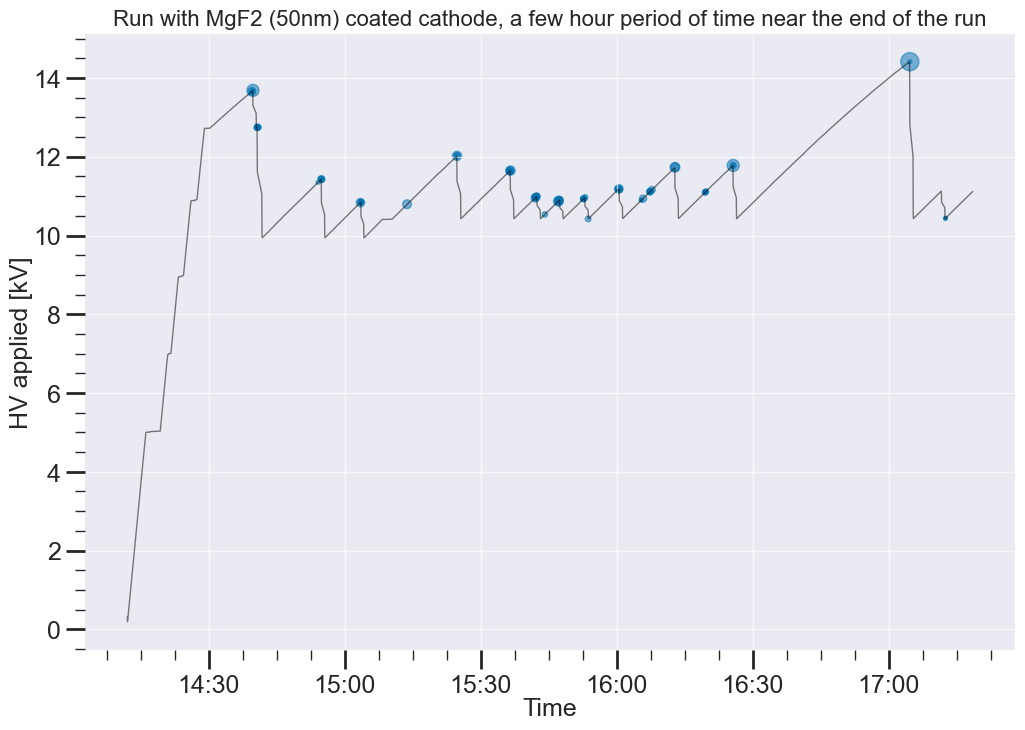

In [34]:
#now we move to a time based history plot that requires a time window
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors[1] = 'darkgreen'
charge_dot_scale = 10

ana = anas[7]
d = ana.df 
d = d[~d["ch3 charge"].isna()]
ana.load_hv_textfiles()
ana.identify_ramps(ref='v_mon')
tdmap = ana.time_duration_map

#tdmap is of the form {"dur":[], "v":[], "t":[]}
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Define the time window using datetime dates
start_date = datetime(2023, 7, 31, 14, 12, 0)
end_date = datetime(2023, 7, 31, 18, 30, 0)

# Convert the datetime dates to timestamps in seconds
start_timestamp = start_date.timestamp()
end_timestamp = end_date.timestamp()
# Filter the tdmap based on the time window
filtered_tdmap = {key: [] for key in tdmap.keys()}
for i, timestamp in enumerate(tdmap["t"]):
    if start_timestamp <= timestamp <= end_timestamp:
        for key in tdmap.keys():
            if(key == "t"):
                filtered_tdmap[key].append(datetime.fromtimestamp(tdmap[key][i]))
            else:
                filtered_tdmap[key].append(tdmap[key][i])


# Plot the high voltage applied during the time window
fig, ax = plt.subplots()
ax.plot(filtered_tdmap["t"], filtered_tdmap["v"], color='k', linewidth=1, alpha=0.5)
ax.set_xlabel("Time")
ax.set_ylabel("HV applied [kV]")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

mask = (d["ch3 seconds"] < end_timestamp) & (d["ch3 seconds"] > start_timestamp) & (d["ch3 n negpeaks"] > 0) & (np.abs(d["ch3 charge"]) > 0.64)
d = d[mask]
# Scatter the ch3 charge events within the time window
ax.scatter([datetime.fromtimestamp(_) for _ in d["ch3 seconds"]], np.abs(d["ch3 hv"]), s=list((np.abs(np.array(d["ch3 charge"]))*charge_dot_scale)), marker='o', alpha=0.5, facecolor=colors[0])
ax.set_title("Run with {} coated cathode, a few hour period of time near the end of the run".format(ana.title))
plt.show()




In [15]:
print(start_date.timestamp())
print(datetime.fromtimestamp(filtered_tdmap["t"][0]))

1690835400.0
2023-07-31 14:11:56.589000


## Comparisons with analytic stored charge and energy

In [118]:
C = 20 #pF
cq = 1.6e-19

dQs = np.array(np.linspace(0.5, 300, 100)) #pC
Vs = np.array(np.linspace(0, 19, 100)) #kV
Es = Vs/0.285
Qs = C*Vs*1000 #pC

U = 0.5*(Qs**2)/(C*1e6) #uJ

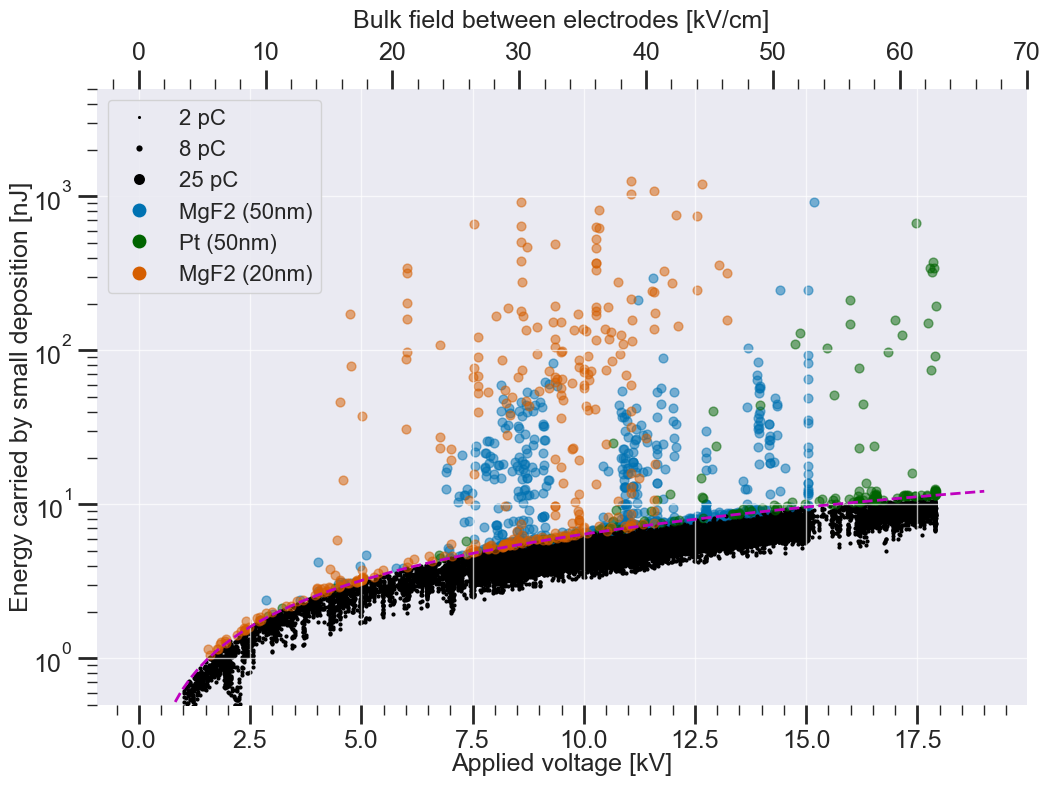

In [143]:
#get charge magnitudes and calculate partial energy
#deposited for each charge event in a run based on what
#voltage / total stored charge is in the gap at that moment. 

fig, ax = plt.subplots()
ax2 = ax.twiny()

hardware_threshold = 0.64 #pC
ax.plot(Vs, hardware_threshold*Vs, 'm--', label="{:.2f} pC threshold".format(hardware_threshold))
for i, run in enumerate([7,8,9]):
    ana = anas[run]
    d =  ana.df
    mask = (~d["ch3 energy"].isna()) & (~d["ch3 charge"].isna())
    d = d[mask]
    #plot noise events
    mask = (d["ch3 hv"] > 1) & (np.abs(d["ch3 charge"]) < hardware_threshold)
    du_evts = d[mask]

    ax.scatter(du_evts["ch3 hv"], np.abs(du_evts["ch3 energy"]), color='k')
    ax2.scatter(du_evts["ch3 field"], du_evts["ch3 energy"], color='k', alpha=0)

    #plot charge events
    mask = (d["ch3 hv"] > 1) & (d["ch3 charge"] < -1*hardware_threshold)
    du_evts = d[mask]

    ax.scatter(du_evts["ch3 hv"], np.abs(du_evts["ch3 energy"]), marker='o', facecolors=colors[i], s=40, label=ana.title, alpha=0.5)



ax.legend(handles=legend_elements, loc='upper left', frameon=True)
ax2.grid(False)
ax2.set_xlabel("Bulk field between electrodes [kV/cm]", labelpad=10)
ax.set_xlabel("Applied voltage [kV]")
ax.set_ylabel("Energy carried by small deposition [nJ]")
#ax.grid(color='k', alpha=0.3)
ax.set_yscale('log')
ax.set_ylim([5e-1, 5e3])

E_f = lambda V:V/0.285
ymin, ymax = ax.get_xlim()
ax2.set_xlim(E_f(ymin), E_f(ymax))

plt.show()

/var/folders/nr/f5dqj57n2yg5k0j2_ffmgmzm0000gn/T/ipykernel_52084/3653748702.py:8: RuntimeWarning: divide by zero encountered in divide
  ax.plot(Vs, hardware_threshold/Qs, 'm--',  label="{:.2f} pC threshold".format(hardware_threshold))


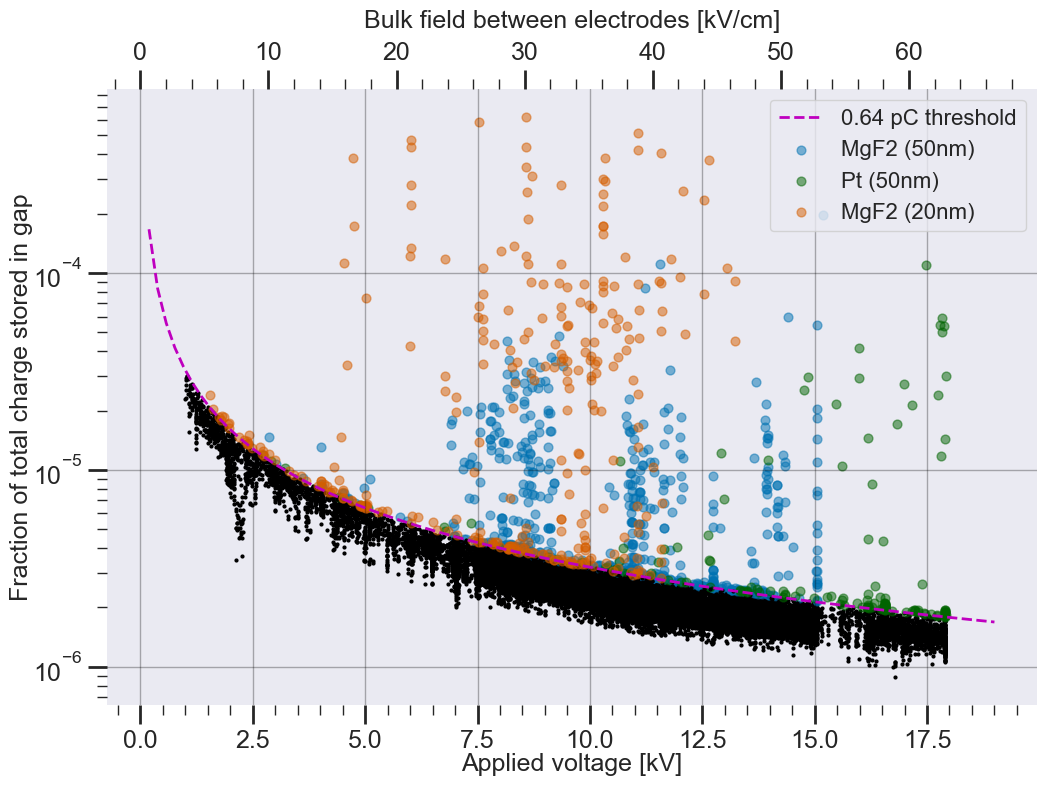

In [146]:
#similar as above, but now fractional stored charge. 

fig, ax = plt.subplots()


ax2 = ax.twiny()
hardware_threshold = 0.64 #pC
ax.plot(Vs, hardware_threshold/Qs, 'm--',  label="{:.2f} pC threshold".format(hardware_threshold))

for i, run in enumerate([7,8,9]):
    ana = anas[run]
    d =  ana.df
    d = d[~d["ch3 charge"].isna()]

    #plot noise events
    mask = (d["ch3 hv"] > 1) & (np.abs(d["ch3 charge"]) < hardware_threshold)
    du_evts = d[mask]
    totalq = C*du_evts["ch3 hv"]*1000
    ax.scatter(du_evts["ch3 hv"], np.abs(du_evts["ch3 charge"])/totalq, color='k')
    ax2.scatter(du_evts["ch3 field"], du_evts["ch3 charge"]/totalq, color='k', alpha=0)

    #plot signal events
    mask = (d["ch3 hv"] > 1) & (d["ch3 charge"] < -1*hardware_threshold)
    du_evts = d[mask]
    totalq = C*du_evts["ch3 hv"]*1000
    ax.scatter(du_evts["ch3 hv"], np.abs(du_evts["ch3 charge"])/totalq, marker='o', facecolors=colors[i], s=40, label=ana.title, alpha=0.5)



ax2.grid(False)
ax2.set_xlabel("Bulk field between electrodes [kV/cm]", labelpad=10)
ax.set_xlabel("Applied voltage [kV]")
ax.set_ylabel("Fraction of total charge stored in gap")
ax.legend(frameon=True)
ax.grid(color='k', alpha=0.3)
ax.set_yscale("log")
E_f = lambda V:V/0.285
ymin, ymax = ax.get_xlim()
ax2.set_xlim(E_f(ymin), E_f(ymax))

plt.show()

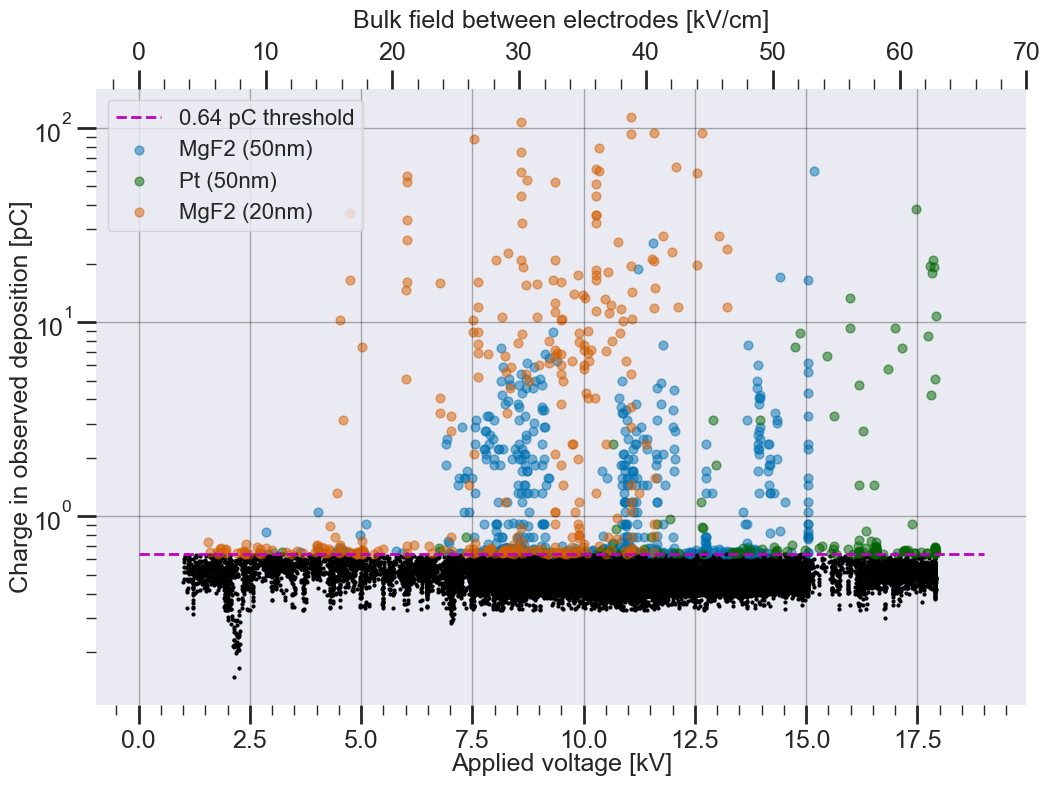

In [140]:
#similar as above, but now stored charge.
fig, ax = plt.subplots()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors[1] = 'darkgreen'

ax2 = ax.twiny()
hardware_threshold = 0.64 #pC

#purple threshold line
ax.plot(Vs, [hardware_threshold]*len(Vs), 'm--',  label="{:.2f} pC threshold".format(hardware_threshold))


for i, run in enumerate([7,8,9]):
    ana = anas[run]
    d =  ana.df
    d = d[~d["ch3 charge"].isna()]

    #plot noise events
    mask = (d["ch3 hv"] > 1) & (np.abs(d["ch3 charge"]) < hardware_threshold)
    du_evts = d[mask]

    ax.scatter(du_evts["ch3 hv"], np.abs(du_evts["ch3 charge"]), color='k')
    ax2.scatter(du_evts["ch3 field"], du_evts["ch3 charge"], color='k', alpha=0)

    #plot signal events
    mask = (d["ch3 hv"] > 1) & (d["ch3 charge"] < -1*hardware_threshold)
    du_evts = d[mask]

    ax.scatter(du_evts["ch3 hv"], np.abs(du_evts["ch3 charge"]), marker='o', facecolors=colors[i], s=40, label=ana.title, alpha=0.5)


ax2.grid(False)
ax2.set_xlabel("Bulk field between electrodes [kV/cm]", labelpad=10)
ax.set_xlabel("Applied voltage [kV]")
ax.set_ylabel("Charge in observed deposition [pC]")
ax.legend(frameon=True)
ax.grid(color='k', alpha=0.3)
ax.set_yscale("log")
E_f = lambda V:V/0.285
ymin, ymax = ax.get_xlim()
ax2.set_xlim(E_f(ymin), E_f(ymax))

plt.show()

# Light analysis

In [106]:
import time
#PMT rates

ana = anas[9]
ana.load_hv_textfiles()
ana.identify_ramps(ref='v_mon')
#an attempt to make code that will give me the HV ramp curve along with
#amplitudes and times of any charge  signals that arrive
tdmap = ana.time_duration_map
light_events = ana.get_light_triggers()
#cast the timestamps into duration space, rounding off
#a few decimal points of the nanosecond bits
#ALSO, only use one channel, as there will be double counting
#if both channels are used. They're all triggered for each event. 
ts = np.array(light_events["ch0 seconds"])
ts_ns = np.array(light_events["ch0 nanoseconds"]).astype(float)
ts_ms = ts + np.round(ts_ns/1.0e9, 3) #now its timestamps with ms precision

rate_binwidth = 60 #seconds
bins = np.arange(min(ts_ms), max(ts_ms), rate_binwidth)
timer0 = time.time()
n, bin_edges = np.histogram(ts_ms, bins=bins)
rate = np.array(n)/rate_binwidth #Hz
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
timer1 = time.time()

#how long is this?
timer0 = time.time()
durs = [ana.get_duration_from_timestamp(_)/3600 for _ in bin_centers]
timer1 = time.time()
print("Duration map took {:.2f} seconds".format(timer1 - timer0))






Duration map took 130.49 seconds


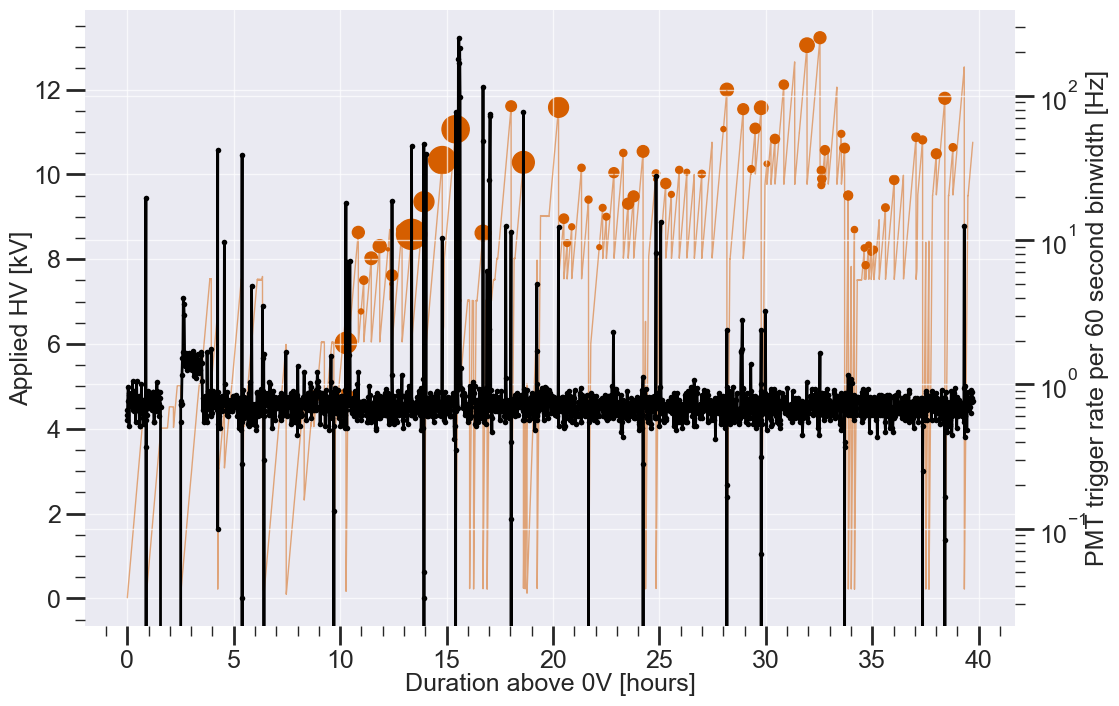

In [108]:
fig, ax = plt.subplots()

d = ana.df
mask = (d["ch3 amp"] > 2) & (d["ch3 amp"] != None)
d_ch = np.array(d[mask]["ch3 charge"])
d_sec = np.array(d[mask]["ch3 seconds"])
d_hv = np.array(d[mask]["ch3 hv"])
d_E = np.array(d[mask]["ch3 field"])

#recast time
hv_event_durs = [ana.get_duration_from_timestamp(_)/3600 for _ in d_sec]
ax.scatter(hv_event_durs, d_hv, s=list(np.array(d_ch)*20), color=colors[2], alpha=1)

ax2 = ax.twinx()
ax.plot(np.array(tdmap["dur"])/3600, tdmap["v"], color=colors[2], linewidth=1, alpha=0.5)
ax2.plot(durs, rate, 'ko-')
#ax.set_xlim([0, 5])
ax2.set_yscale('log')
ax.set_ylabel("Applied HV [kV]")
ax.set_xlabel("Duration above 0V [hours]")
ax2.set_ylabel("PMT trigger rate per 60 second binwidth [Hz]")
plt.show()


In [99]:
import time
#PMT rates

ana = anas[7]
ana.load_hv_textfiles()
ana.identify_ramps(ref='v_mon')
#an attempt to make code that will give me the HV ramp curve along with
#amplitudes and times of any charge  signals that arrive
tdmap = ana.time_duration_map
light_events = ana.get_light_triggers()
#cast the timestamps into duration space, rounding off
#a few decimal points of the nanosecond bits
#ALSO, only use one channel, as there will be double counting
#if both channels are used. They're all triggered for each event. 
ts = np.array(light_events["ch0 seconds"])
ts_ns = np.array(light_events["ch0 nanoseconds"]).astype(float)
ts_ms = ts + np.round(ts_ns/1.0e9, 3) #now its timestamps with ms precision

rate_binwidth = 60 #seconds
bins = np.arange(min(ts_ms), max(ts_ms), rate_binwidth)
timer0 = time.time()
n, bin_edges = np.histogram(ts_ms, bins=bins)
rate = np.array(n)/rate_binwidth #Hz
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
timer1 = time.time()

#how long is this?
timer0 = time.time()
durs = [ana.get_duration_from_timestamp(_)/3600 for _ in bin_centers]
timer1 = time.time()
print("Duration map took {:.2f} seconds".format(timer1 - timer0))






Duration map took 30.27 seconds


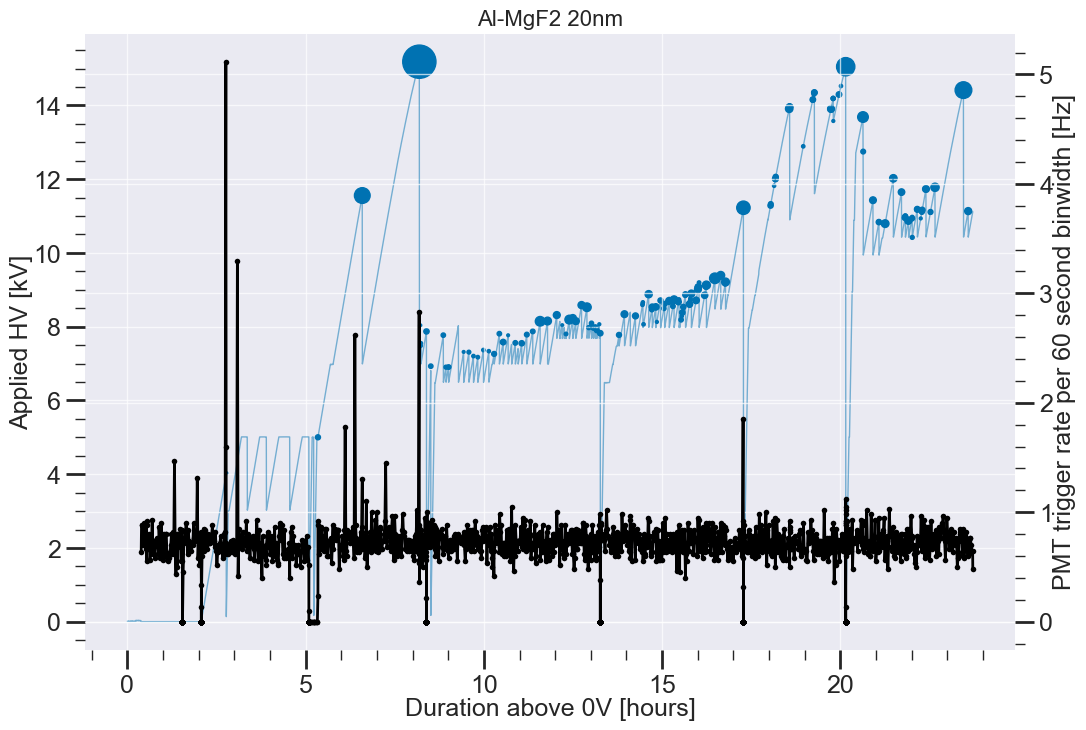

In [102]:
fig, ax = plt.subplots()

d = ana.df
mask = (d["ch3 amp"] > 2) & (d["ch3 amp"] != None)
d_ch = np.array(d[mask]["ch3 charge"])
d_sec = np.array(d[mask]["ch3 seconds"])
d_hv = np.array(d[mask]["ch3 hv"])
d_E = np.array(d[mask]["ch3 field"])

#recast time
hv_event_durs = [ana.get_duration_from_timestamp(_)/3600 for _ in d_sec]
ax.scatter(hv_event_durs, d_hv, s=list(np.array(d_ch)*20), color=colors[0], alpha=1)

ax2 = ax.twinx()
ax.plot(np.array(tdmap["dur"])/3600, tdmap["v"], color=colors[0], linewidth=1, alpha=0.5)
ax2.plot(durs, rate, 'ko-')
#ax.set_xlim([0, 5])
#ax2.set_xlim([0, 5])
ax.set_ylabel("Applied HV [kV]")
ax.set_xlabel("Duration above 0V [hours]")
ax2.set_ylabel("PMT trigger rate per 60 second binwidth [Hz]")
ax.set_title("Al-MgF2 20nm")
plt.show()
